In [1]:
import pandas as pd
import numpy as np
import subprocess
from glob import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
EUR_path = "%s/genetic_score/EUR" % export_folder
betas_path = "%s/Genetic_score_Sysmex_traits/betas.csv" % (export_folder)
tag = "20_dec_21"
snp_path = "%s/conditional_analysis/causal_SNPs_BOLT_%s_%s.txt" % (export_folder,tag,"ADP_pred")
n_splits = 12

In [3]:
pheno_cols = ["ADP_pred"]

In [12]:
for chrom in range(1,23):
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.bgen" % chrom
    command += " --sample /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.sample" % chrom
    command += " --extract %s" % snp_path
    command += " --score %s header-read center" % betas_path
    if len(pheno_cols) > 1:
        command += " --score-col-nums 3-%d" % (2 + len(pheno_cols))
    else:
        command += " --score-col-nums 3"
    command += " --out %s/Genetic_score_PFC/good_score_chr%s" % (export_folder,chrom)
    command += " --threads %d" % n_splits
    
    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_PFC.sh" % (chrom)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J PF-chr-%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=1:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_PFC_%s.out\n" % ("GS",chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


In [13]:
command

'/home/hv270/Plink2/plink2 --bgen /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.22.imputed.non_zero_maf.bgen --sample /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.22.imputed.non_zero_maf.sample --extract /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/conditional_analysis/causal_SNPs_BOLT_20_dec_21_ADP_pred.txt --score /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/betas.csv header-read center --score-col-nums 3 --out /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_PFC/good_score_chr22 --threads 12'

# Read results

In [14]:
r_files = sorted(glob("%s/Genetic_score_PFC/good_score_chr*.sscore" % (export_folder)))

In [15]:
dfs = []
for f in r_files:
    df = pd.read_csv(f,sep="\t")
    dfs.append(df)

In [16]:
scores = pd.concat(dfs,axis=0).groupby("IID")[[c for c in dfs[-1].columns if "AVG" in c]].sum()
scores_cols = scores.columns
for col in scores_cols:
    scores = scores.rename(columns={col:col[:-4]})

In [17]:
scores

,ADP_pred
IID,
a550484-4321705-042718-460_A03.CEL,0.137749
a550484-4321705-042718-460_A05.CEL,0.013198
a550484-4321705-042718-460_A07.CEL,0.087137
a550484-4321705-042718-460_A08.CEL,-0.110322
a550484-4321705-042718-460_A09.CEL,0.031776
...,...
a550484-4327674-062018-910_H02.CEL,-0.097465
a550484-4327674-062018-910_H03.CEL,-0.009227
a550484-4327674-062018-910_H04.CEL,0.161603


# Read phenotypes

In [18]:
phenotypes = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_phenotypes/phenotypes.tsv",sep="\t")

In [19]:
phenotypes

,Affy,REST,ADP,CRP,PAR1,PAR4,TRAP,ADP_FIB_ONLY
0,a550484-4321705-042718-460_A03.CEL,NaN,-0.599679,0.920030,0.511746,0.564012,0.702715,NaN
1,a550484-4321705-042718-460_A05.CEL,NaN,1.487113,1.420275,-0.053452,0.914320,-0.314637,NaN
2,a550484-4321705-042718-460_A07.CEL,NaN,-0.357455,0.989093,NaN,NaN,NaN,NaN
3,a550484-4321705-042718-460_A08.CEL,NaN,-1.719555,-1.075165,NaN,NaN,NaN,NaN
4,a550484-4321705-042718-460_A09.CEL,NaN,-1.121549,0.181230,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1368,a550484-4327674-062018-910_H02.CEL,-0.785120,NaN,-2.222151,NaN,NaN,NaN,-1.608514
1369,a550484-4327674-062018-910_H03.CEL,0.280245,NaN,0.678366,NaN,NaN,NaN,0.088883
1370,a550484-4327674-062018-910_H04.CEL,-1.014169,NaN,-0.913385,NaN,NaN,NaN,0.498999
1371,a550484-4327674-062018-910_H05.CEL,1.856044,NaN,1.985790,NaN,NaN,NaN,0.153684


# Exclude people from the training cohort

In [20]:
data_folder = "/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only"
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

matching = pd.read_csv("%s/pfc_table/hippo_pfc_match_table.tsv" % data_folder,sep="\t")
will_pheno = pd.read_csv("%s/pfc_phenotypes/phenotypes.tsv" % data_folder,sep="\t")
hipp_pheno = pd.read_csv("%s/processed/phenotypes.csv" % data_dir,index_col=0).set_index("SAMPLE_ID")

In [21]:
will_pheno["Affy"] = will_pheno["Affy"].str[:-4]
will_pheno = pd.merge(will_pheno, matching, left_on="Affy",right_on="Affy")

In [22]:
both = pd.merge(will_pheno,hipp_pheno,left_on="SAMPLE_ID",right_index=True,suffixes=("_will","_hippo"))

In [23]:
to_exclude = [ID+".CEL" for ID in both.Affy.unique().tolist()]

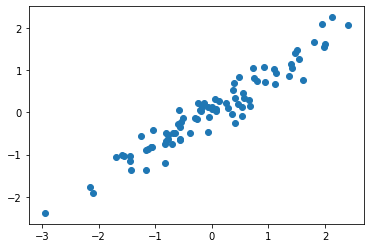

In [24]:
plt.scatter(both["ADP_will"],both["ADP_hippo"])

In [25]:
matching.head()

,PROJECT,SAMPLE_ID,Affy
0,PFC_1,100010100138,a550484-4327674-062018-907_B10
1,PFC_1,100010100139,a550484-4327674-062018-906_A04
2,PFC_1,100010100140,a550484-4324983-042818-484_F07
3,PFC_1,100010100141,NaN
4,PFC_1,100010100142,a550484-4326140-061918-707_B02


In [26]:
matching["Affy"] = matching["Affy"] + ".CEL"

In [27]:
phenotypes = pd.merge(phenotypes,matching,left_on="Affy",right_on="Affy",how="left")

# Do the comparison

In [28]:
comp = pd.merge(scores,phenotypes,left_index=True,right_on="Affy")
#comp = comp.loc[~comp.Affy.isin(to_exclude)]

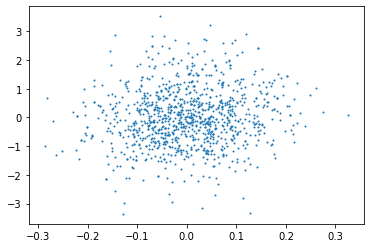

In [29]:
plt.scatter(comp["ADP_pred"],comp["ADP"],s=1)

In [37]:
no_nan = ~comp["ADP"].isnull() 
no_overlap = comp["PROJECT"] != "PFC_4_U"
pearsonr(comp.loc[no_nan & no_overlap,"ADP_pred"],comp.loc[no_nan & no_overlap,"ADP"])

(0.09638379907491491, 0.0029267192688210114)

In [36]:
no_nan = ~comp["ADP_FIB_ONLY"].isnull()
pearsonr(comp.loc[no_nan,"ADP_pred"],comp.loc[no_nan,"ADP_FIB_ONLY"])

(0.07959880987367234, 0.12694062691914731)

In [ ]:
def pearson_corr(df, col1,col2):
    cond = ~df[col1].isnull() & ~df[col2].isnull()
    print(cond.sum())
    if cond.sum() == 0: return None
    return pearsonr(df.loc[cond,col1],df.loc[cond,col2])

In [31]:
comp

,ADP_pred,Affy,REST,ADP,CRP,PAR1,PAR4,TRAP,ADP_FIB_ONLY,PROJECT,SAMPLE_ID
0,0.137749,a550484-4321705-042718-460_A03.CEL,NaN,-0.599679,0.920030,0.511746,0.564012,0.702715,NaN,PFC_3,C0BEKP
1,0.013198,a550484-4321705-042718-460_A05.CEL,NaN,1.487113,1.420275,-0.053452,0.914320,-0.314637,NaN,PFC_3,C09UHK
2,0.087137,a550484-4321705-042718-460_A07.CEL,NaN,-0.357455,0.989093,NaN,NaN,NaN,NaN,PFC_1,100010100334
3,-0.110322,a550484-4321705-042718-460_A08.CEL,NaN,-1.719555,-1.075165,NaN,NaN,NaN,NaN,PFC_1,100010100351
4,0.031776,a550484-4321705-042718-460_A09.CEL,NaN,-1.121549,0.181230,NaN,NaN,NaN,NaN,PFC_1,100010100319
...,...,...,...,...,...,...,...,...,...,...,...
1433,-0.097465,a550484-4327674-062018-910_H02.CEL,-0.785120,NaN,-2.222151,NaN,NaN,NaN,-1.608514,PFC_2,710
1434,-0.009227,a550484-4327674-062018-910_H03.CEL,0.280245,NaN,0.678366,NaN,NaN,NaN,0.088883,PFC_2,829
1435,0.161603,a550484-4327674-062018-910_H04.CEL,-1.014169,NaN,-0.913385,NaN,NaN,NaN,0.498999,PFC_2,1043
1436,0.164646,a550484-4327674-062018-910_H05.CEL,1.856044,NaN,1.985790,NaN,NaN,NaN,0.153684,PFC_2,1309


In [32]:
for project, df in comp.groupby("PROJECT"):
    print(project)
    print(pearson_corr(df,"ADP_pred","ADP"))

PFC_1
414
(0.05490523181445266, 0.26501355940508975)
PFC_2
0
None
PFC_3
537
(0.1290330662647748, 0.0027383239869598905)
PFC_4_U
86
(0.23398044256215178, 0.0301367399159271)


In [33]:
for project, df in comp.groupby("PROJECT"):
    print(project)
    print(pearson_corr(df,"ADP_pred","ADP_FIB_ONLY"))

PFC_1
0
None
PFC_2
369
(0.07959880987367234, 0.12694062691914731)
PFC_3
0
None
PFC_4_U
0
None
